# Pure Random Walk Simulation

Q: How well can a cell find high ligand concentration using just random walk?

The file includes:
 - Model specification
 - Visualizing the trajectories for 3 cells in response to gradients with different background tumbling frequencies
 - Measuring collective performance of cells

## Part1: Model specification

#### Assumptions
1. Run. The duration of run follows an exponential distrubtion with mean equals to the background run duration `time_exp`.
2. Tumble. The duration of cell tumble follows an exponential distribution with mean 0.1s. When it tumbles, we assume it only changes the orientation for the next run but doesn't move in space. The degree of reorientation follows a uniform distribution of 0° to 360°.
3. Gradient. We model an exponential gradient centered at [1500, 1500] with a concentration of 10^8. All cells start at [0, 0], which has a concentration of 10^2. The receptors saturate at a concentration of 10^8. 
5. Performance. The closer to the center of the gradient the better.

#### Dependencies
Please makes sure have dependencies installed:
 - [Numpy](https://numpy.org/install/)
 - [Matplotlib](https://matplotlib.org/users/installing.html)
 - [Colorspace](https://python-colorspace.readthedocs.io/en/latest/installation.html) (simply [install with pip](https://pypi.org/project/colorspace/) works too)

In [19]:
!pip install git+https://github.com/retostauffer/python-colorspace

  Cloning https://github.com/retostauffer/python-colorspace to /tmp/pip-req-build-jcn1qgx1
  Running command git clone -q https://github.com/retostauffer/python-colorspace /tmp/pip-req-build-jcn1qgx1
  Created wheel for colorspace: filename=colorspace-0.1.0-py3-none-any.whl size=246151 sha256=2190a6865ea32b75fe8320c5ffa557a684699c4ef0aa4060ea6f4cff58f76cce
  Stored in directory: /tmp/pip-ephem-wheel-cache-ozr10_lu/wheels/4c/85/1a/735d407a4e83f87c2af1b0f535cc12a440e1b20cfd640cb21c
Successfully built colorspace
  Attempting uninstall: colorspace
    Found existing installation: colorspace 0.0.1
    Uninstalling colorspace-0.0.1:
      Successfully uninstalled colorspace-0.0.1


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib import colors
from matplotlib import patches
import colorspace

#### Specifying parameters

In [21]:
SEED = 128  #Any random seed
np.random.seed(SEED) #set seed for Numpy random number generator

#Constants for E.coli tumbling
tumble_time_mu = 0.1 #second

#E.coli movement constants
speed = 20         #um/s, speed of E.coli movement

#Model constants
start = [0, 0]  #All cells start at [0, 0]
ligand_center = [1500, 1500] #Position of highest concentration
center_exponent, start_exponent = 8, 2 #exponent for concentration at [1500, 1500] and [0, 0]
origin_to_center = 0 #Distance from start to center, intialized here, will be actually calculated later
saturation_conc = 10 ** 8 #From BNG model

#### Helper function: calculate Euclidean distance

In [ ]:
# Calculates Euclidean distance between point a and b
# Input: positions a, b. Each in the form array [x, y]
# Returns the distance, a float.
def euclidean_distance(a, b):
    return math.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

#### Function to calculate concentration at a current location
We model an exponential gradient centered at [1500, 1500] with a concentration of 10^8. All cells start at [0, 0], which has a concentration of 10^2.

In [ ]:
# Calculates the concentration of a given position
# Exponential gradient, the exponent follows a linear relationship with distance to center
# Input: position pos, [x, y]
# Returns the concentration, a float.
def calc_concentration(pos):
    dist = euclidean_distance(pos, ligand_center)
    exponent = (1 - dist / origin_to_center) * (center_exponent - start_exponent) + start_exponent
    
    return 10 ** exponent

#### Function to calculate tumble duration and reorientation

The duration of cell tumble follows an exponential distribution with mean 0.1s. When it tumbles, we assume it only changes the orientation for the next run but doesn't move in space. 

The degree of reorientation follows a uniform distribution between 0° and 360°.

Also return the horizontal and vertical movement of the cell for the following run.

In [ ]:
# Samples the new direction and time of a tumble
# Calculates projection on the Horizontal and Vertical direction for the next move
# No input
# Return the horizontal movement projection (float), the vertical one (float), tumble time (float)
def tumble_move():
    #Sample the new direction unformly from 0 to 2pi, record as a float
    new_dir = np.random.uniform(low = 0.0, high = 2 * math.pi)
        
    projection_h = math.cos(new_dir) #displacement projected on Horizontal direction for next run, float
    projection_v = math.sin(new_dir) #displacement projected on Vertical direction for next run, float
    
    #Length of the tumbling sampled from exponential distribution with mean=0.1, float
    tumble_time = np.random.exponential(tumble_time_mu)
    
    return projection_h, projection_v, tumble_time

#### Function for simulation

It handles simulation through time for all cells.

For each cell, simulate through time as the following:

while `t` < duration:
- Sample the current run duration `curr_run_time`
- Run for `curr_run_time` second along current direction
- Sample the duration of tumble `tumble_time` and the resulted direction
- increment t by `curr_run_time` and `tumble_time`

In [ ]:
# This function performs simulation
# Input: number of cells to simulate (int), how many seconds (int), the expected run time before tumble (float)
# Return: the simulated trajectories paths: array of shape (num_cells, duration+1, 2)
def simulate_std_random(num_cells, duration, run_time_expected):
    
    #Takes the shape (num_cells, duration+1, 2)
    #any point [x,y] on the simulated trajectories can be accessed via paths[cell, time]
    paths = np.zeros((num_cells, duration + 1, 2))

    for rep in range(num_cells):
        # Initialize simulation
        t = 0 #record the time elapse
        curr_position = np.array(start) #start at [0, 0]
        projection_h, projection_v, tumble_time = tumble_move() #Initialize direction randomly
        past_sec = 0

        while t < duration:
            
            #run
            curr_run_time = np.random.exponential(run_time_expected) #get run duration, float
            #displacement on either direction is calculated as the projection * speed * time
            #update current position by summing old position and displacement
            curr_position = curr_position + np.array([projection_h, projection_v]) * speed * curr_run_time
            
            #tumble
            projection_h, projection_v, tumble_time = tumble_move()
            
            #increment time
            t += (curr_run_time + tumble_time)

            #record position approximate for integer number of second
            curr_sec = int(t)
            for sec in range(past_sec, min(curr_sec, duration) + 1):
                #fill values from last time point to current time point
                paths[rep, sec] = curr_position.copy()
                past_sec= curr_sec
    
    return paths

## Part2: Visualizing trajectories

Run simulations for `time_exp` = 1.0, 3 cells, for 800 seconds.

In [ ]:
#Run simulation for 3 cells with different background tumbling frequencies, Plot paths

duration = 800  #seconds, duration of the simulation, int
num_cells = 3   #number of cells, int
origin_to_center = euclidean_distance(start, ligand_center) #Update the global constant
run_time_expected = 1.0 #expected run time before tumble, float

#Calls the simulate function
paths = simulate_std_random(num_cells, duration, run_time_expected) #get the simulated trajectories
print(paths[:,-1,:]) #print the terminal poistion of each simulation

[[  29.80120945  178.32219275]
 [-383.71671925  528.81886147]
 [  47.75523372  -95.40434247]]


#### Plotting the trajectories.

It will take some time to run.

- The background color white->red indicates ligand concentration
- Black dot indicates starting position of all cells ([0, 0]).
- Red dot indicates terminal position of all cells.
- The dashed line with colors dark->ligt green/cyan/purple indicates trajectories of the three cells. Darker dots indicate earlier time points.
- If the center has a higher concentration than 10^8 (saturation), the dark dashed circle indicates inside which concentration>10^8.

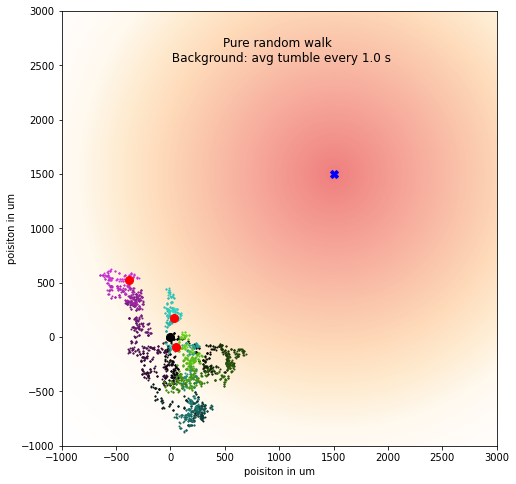

In [ ]:
#Below are all for plotting purposes
#Initialize the plot with 1*1 subplot of size 8*8
fig, ax = plt.subplots(1, 1, figsize = (8, 8))

#First set color map to color-code the concentration
mycolor = [[256, 256, 256], [256, 255, 254], [256, 253, 250], [256, 250, 240], [255, 236, 209], [255, 218, 185], [251, 196, 171], [248, 173, 157], [244, 151, 142], [240, 128, 128]] #RGB values, from coolors：）
for i in mycolor:
    for j in range(len(i)):
        i[j] *= (1/256) #normalize to 0~1 range
cmap_color = colors.LinearSegmentedColormap.from_list('my_list', mycolor) #Linearly segment these colors to create a continuous color map

#Store the concentrations for each integer position in a matrix
conc_matrix = np.zeros((4000, 4000)) #we will display from [-1000, -1000] to [3000, 3000]
for i in range(4000):
    for j in range(4000):
        conc_matrix[i][j] = math.log(calc_concentration([i - 1000, j - 1000])) #calculate the exponents of concentrations at each location

#Simulate the gradient distribution, plot as a heatmap
ax.imshow(conc_matrix.T, cmap=cmap_color, interpolation='nearest', extent = [-1000, 3000, -1000, 3000], origin = 'lower')

#Plot simulation results
time_frac = 1.0 / duration
#Plot the trajectories. Time progress: dark -> colorful
for t in range(duration):
    ax.plot(paths[0,t,0], paths[0,t,1], 'o', markersize = 1, color = (0.2 * time_frac * t, 0.85 * time_frac * t, 0.8 * time_frac * t))
    ax.plot(paths[1,t,0], paths[1,t,1], 'o', markersize = 1, color = (0.85 * time_frac * t, 0.2 * time_frac * t, 0.9 * time_frac * t))
    ax.plot(paths[2,t,0], paths[2,t,1], 'o', markersize = 1, color = (0.4 * time_frac * t, 0.85 * time_frac * t, 0.1 * time_frac * t))
ax.plot(start[0], start[1], 'ko', markersize = 8) #Mark the starting point [0, 0]
for i in range(num_cells):
    ax.plot(paths[i,-1,0], paths[i,-1,1], 'ro', markersize = 8) #Mark the terminal points for each cell

ax.plot(1500, 1500, 'bX', markersize = 8) #Mark the highest concentration point [1500, 1500]
ax.set_title("Pure random walk \n Background: avg tumble every {} s".format(run_time_expected), x = 0.5, y = 0.87)
ax.set_xlim(-1000, 3000)
ax.set_ylim(-1000, 3000)
ax.set_xlabel("poisiton in um")
ax.set_ylabel("poisiton in um")

plt.show()

## Part3: Measuring collective performances

Run simulations for 500 cells, for 1500 seconds. Mean and std for Euclidean distance to the center are calculated at each time point.

It will take some time to run.

In [ ]:
#Run simulation for 500 cells, plot average distance to highest concentration point
duration = 1500   #seconds, duration of the simulation
num_cells = 500 #number of cells, intorigin_to_center = euclidean_distance(start, ligand_center) #Update the global constant
origin_to_center = euclidean_distance(start, ligand_center) #Update the global constant
run_time_expected = 1.0 #expected run time before tumble, float

all_distance = np.zeros((num_cells, duration)) #Initialize to store results, array with shape (num_cells, duration)

pathss = simulate_std_random(num_cells, duration, run_time_expected) #run simulation

for cell in range(num_cells):
    for time in range(duration):
        pos = pathss[cell, time] #get the position [x,y] for the cell at a given time
        dist = euclidean_distance(ligand_center, pos) #calculate the Euclidean distance between that position to [1500, 1500]
        all_distance[cell, time] = dist #record this distance

# For all time, take average and standard deviation over all cells.
all_dist_avg = np.mean(all_distance, axis = 0) #Calculate average over cells, array of shape (duration,)
all_dist_std = np.std(all_distance, axis = 0) #Calculate the standard deviation, array of shape (duration,)

#### Plotting distances.

- Each colored line indicates a `time_exp`, plotting average distances for the 500 cells
- The shaded area is standard deviation
- Grey dashed line indicates distance below where concentration reaches 10^8.

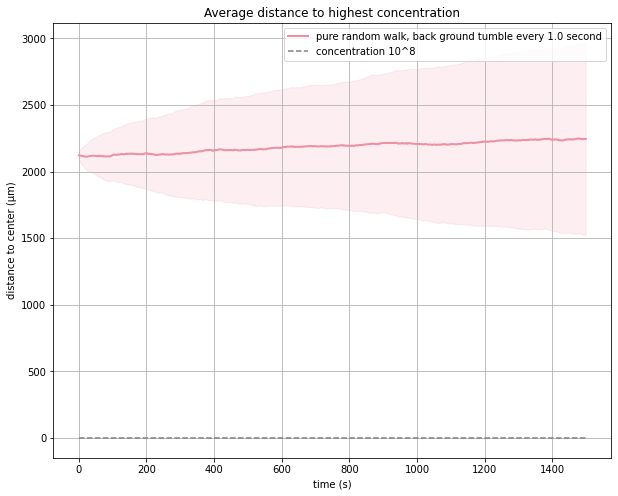

In [22]:
#Below are all for plotting purposes
#Define the colors to use
colors1 = colorspace.qualitative_hcl(h=[0, 300.], c = 60, l = 70, pallete = "dynamic")(1)

xs = np.arange(0, duration) #Set the x-axis for plot: time points. Array of integers of shape (duration,)

fig, ax = plt.subplots(1, 1, figsize = (10, 8)) #Initialize the plot with 1*1 subplot of size 10*8

mu, sig = all_dist_avg, all_dist_std
#Plot average distance vs. time
ax.plot(xs, mu, lw=2, label="pure random walk, back ground tumble every {} second".format(run_time_expected), color=colors1[0])
#Fill in average +/- one standard deviation vs. time
ax.fill_between(xs, mu + sig, mu - sig, color = colors1, alpha=0.15)

ax.set_title("Average distance to highest concentration")
ax.set_xlabel('time (s)')
ax.set_ylabel('distance to center (µm)')
ax.hlines(0, 0, duration, colors='gray', linestyles='dashed', label='concentration 10^8')
ax.legend(loc='upper right')

ax.grid()